In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# imports for time series analysis
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm

# imports for time series forecasting
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.performance_metrics.forecasting import *
from sktime.forecasting.naive import NaiveForecaster

# call ARIMA (includes sarima/sarimax) model
from statsmodels.tsa.arima.model import ARIMA

## another SARIMAX implementation from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

# box-cox transformation for skeewed data
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# data transformation functions

# find best boxcox transformation. Include datetime index if given
def boxcox_transform(x,lmda=None,alpha=None,optimizer=None):
    if type(x) == pd.core.frame.DataFrame:
        index = x.index
        name = x.name
        if lmda == None:
            boxcox_data, lmda = boxcox(x, lmbda=None, alpha=None, optimizer=None)

            boxcox_data = pd.DataFrame(boxcox_data, index=index, columns=[name])
            return boxcox_data, lmda
        else:
            boxcox_data = boxcox(x, lmbda=lmda, alpha=None, optimizer=None)

            boxcox_data = pd.DataFrame(boxcox_data, index=index, columns=[name])

            return boxcox_data
    elif type(x) == pd.core.series.Series:
        index = x.index
        name = x.name
        if lmda == None:
            boxcox_data, lmda = boxcox(x, lmbda=None, alpha=None, optimizer=None)

            boxcox_data = pd.Series(data=boxcox_data, index=index, name=name)
            
            return boxcox_data, lmda
        else:
            boxcox_data = boxcox(x, lmbda=lmda, alpha=None, optimizer=None)

            boxcox_data = pd.DataFrame(boxcox_data, index=index, columns=[name])

            return boxcox_data
    else:
        if lmda == None:
            boxcox_data, lmda = boxcox(x, lmbda=None, alpha=None, optimizer=None)
            return boxcox_data, lmda
        else:
            boxcox_data = boxcox(x, lmbda=lmda, alpha=None, optimizer=None)
            return boxcox_data

# reverse transformation. Include datetime index if given
def inv_boxcox_tranform(x, lmda, out=None):

    reversed_data = inv_boxcox(x, lmda, out=None)

    if type(x) == pd.core.frame.DataFrame:
        index = x.index
        name = x.name

        reversed_data = pd.DataFrame(reversed_data, index=index, columns=[name])

        return reversed_data

    elif type(x) == pd.core.series.Series:
        index = x.index
        name = x.name
        
        return reversed_data
        
    else:
        return reversed_data


import warnings
warnings.filterwarnings("ignore")

# load inflow dataset into dataframe
#inflow_data = pd.read_excel("../InflowData_1.xlsx")
inflow_data = pd.read_csv("../data/inflow_imputed.csv")

# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
#inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")
inflow_data.index = pd.to_datetime(inflow_data.index)

# make list with dma names
dma_list = list(inflow_data.columns.values)

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

# # print first two rows
# inflow_data.head(3)

In [2]:
# weather data
weather_data = pd.read_csv("../data/weather_imputed.csv")

# change index of weather dataframe to time step
weather_data = weather_data.set_index('Date-time CET-CEST (DD/MM/YYYY HH:mm)')

# change index format to datetime
weather_data.index = pd.to_datetime(weather_data.index)

In [3]:
# make list of special days for the DMAs region
official_holidays = ["2021-01-01","2021-01-06","2021-04-04","2021-04-05","2021-04-25","2021-05-01","2021-06-02","2021-08-15","2021-11-01","2021-12-05","2021-12-25","2021-12-26","2022-01-01","2022-01-06","2022-04-17","2022-04-18","2022-04-25","2022-05-01","2022-06-22","2022-08-15","2022-11-01","2022-12-08","2022-12-25","2022-12-26"]

legally_not_recongnized_holidays = ["2021-04-23","2021-05-23","2022-04-23","2022-06-05"]

event_day = ["2021-03-28","2021-05-09","2021-10-31","2021-11-28","2021-05-12","2021-12-12","2021-12-19","2021-12-31","2022-03-27","2022-04-10","2022-05-08","2022-05-09","2022-10-30","2022-11-27","2022-12-04","2022-12-11","2022-12-18","2022-12-31"]

# make columns for special days
weather_data['official_holiday'] = 0
weather_data['legally_not_recongnized_holidays'] = 0
weather_data['event_day'] = 0
weather_data['weekend'] = 0

# add indicator variable for speciall days
for i in weather_data.index:
    if str(i)[:10] in official_holidays:
        weather_data['official_holiday'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in legally_not_recongnized_holidays:
        weather_data['legally_not_recongnized_holidays'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in event_day:
        weather_data['event_day'][i] = 0

# add variable for weekend days
for i in weather_data.index:
    if i.weekday() == 5 or i.weekday() == 6:
        weather_data['weekend'][i] = 1

In [ ]:
# drop uncorrelated features
weather_data = weather_data.drop(['Rainfall depth (mm)','Air humidity (%)','Windspeed (km/h)'], axis=1)

In [4]:
# create an utility metric function
def print_metrics(y_obs,y_pred, model_name,return_df=None):
    MeanAE_24h = 1/24 * np.sum(np.abs(y_obs[0:24] - y_pred[0:24]))

    MaxAE_24h = np.max(np.abs(y_obs[0:24] - y_pred[0:24]))

    MeanAE_144h = 1/144 * np.sum(np.abs(y_obs[24:168] - y_pred[24:168]))

    total_sum = np.sum(MeanAE_24h + MaxAE_24h + MeanAE_144h)

    dict_ = {'MeanAE-24h': MeanAE_24h, 'MaxAE-24h': MaxAE_24h,
             'MeanAE-144h': MeanAE_144h, 'Total': total_sum}
    
    df = pd.DataFrame(dict_, index = [model_name])
    
    print(model_name)
    print(f"MeanAE-24h      MaxAE-24h      MeanAE-144h      Total")
    print(f"{MeanAE_24h:.2f}            {MaxAE_24h:.2f}             {MeanAE_144h:.2f}           {total_sum:.2f} \n")
    if return_df == 1:
        return(df.round(decimals = 3))

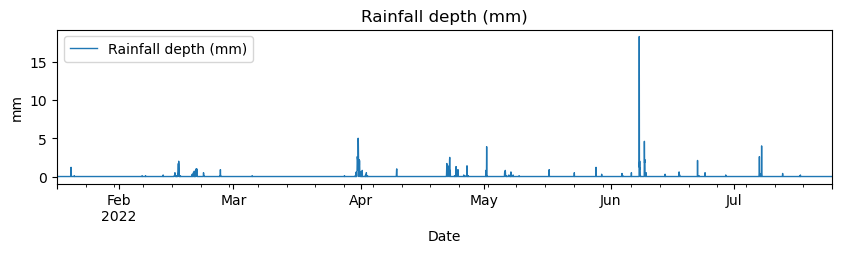

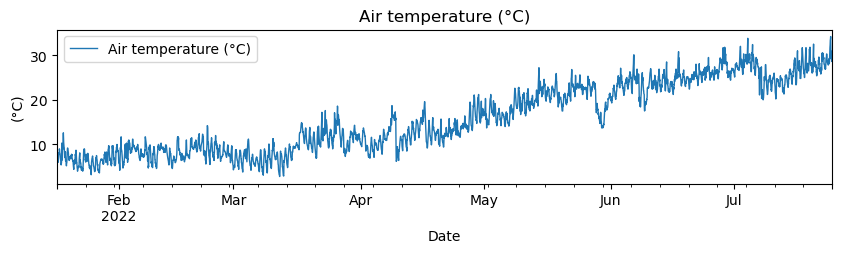

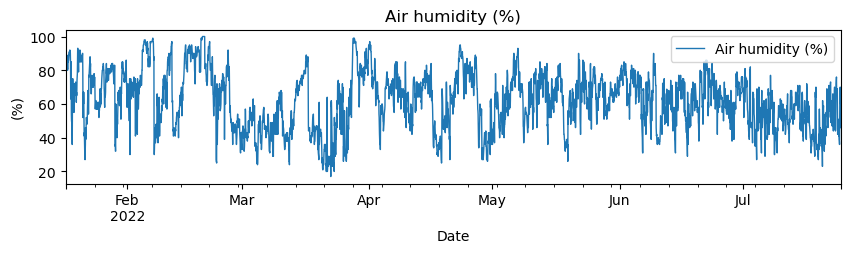

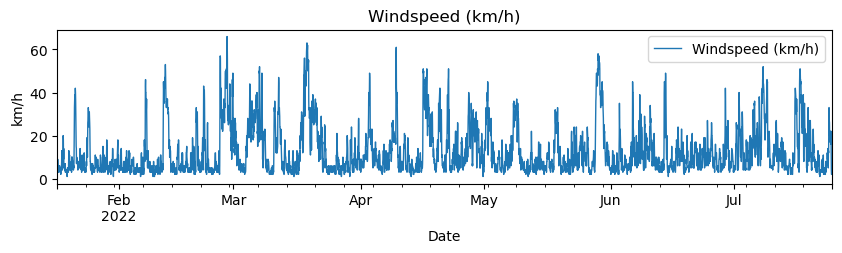

In [5]:
# define start and end dates for analysis (last week is used for evaluation)
start = '2022-01-17'
end = '2022-07-24'

# make feature time series dataframe
tseriesX_df = weather_data.copy()

# reduce time series to specified start and end dates
tseriesX_df = tseriesX_df[start:end].copy()

# make train and test sets
X = tseriesX_df
X_train, X_test = temporal_train_test_split(X, test_size=168)

# fill missing values with interpolation technique
#tseriesX_df.interpolate(limit_direction='both',inplace=True)

## visualize weather data

# RAINFALL
var = 'Rainfall depth (mm)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("mm")
plt.legend()
plt.show()

# AIR TEMPERATURE
var = 'Air temperature (°C)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("(°C)")
plt.legend()
plt.show()

# AIR HUMIDITY
var = 'Air humidity (%)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("(%)")
plt.legend()
plt.show()

# WINDSPEED
var = 'Windspeed (km/h)'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("km/h")
plt.legend()
plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.93813D+00    |proj g|=  2.55447D-01


 This problem is unconstrained.



At iterate    5    f=  1.83949D+00    |proj g|=  4.26020D-01

At iterate   10    f=  1.79714D+00    |proj g|=  5.88039D-02

At iterate   15    f=  1.77385D+00    |proj g|=  2.98683D-02

At iterate   20    f=  1.77259D+00    |proj g|=  1.37428D-02

At iterate   25    f=  1.76455D+00    |proj g|=  9.77312D-02

At iterate   30    f=  1.75770D+00    |proj g|=  2.16248D-02

At iterate   35    f=  1.75349D+00    |proj g|=  3.12807D-02

At iterate   40    f=  1.74963D+00    |proj g|=  7.98891D-02

At iterate   45    f=  1.74765D+00    |proj g|=  3.59452D-02

At iterate   50    f=  1.74585D+00    |proj g|=  1.58334D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

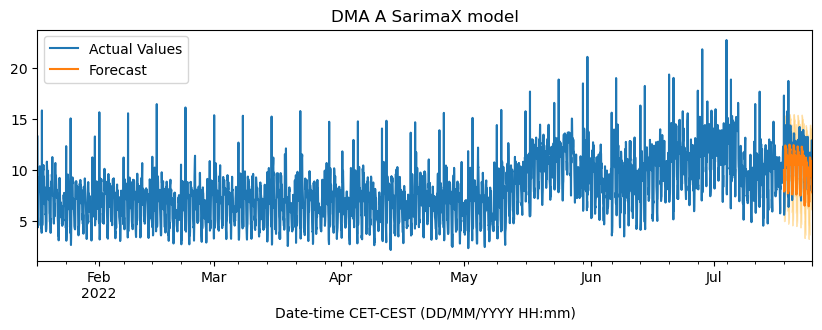

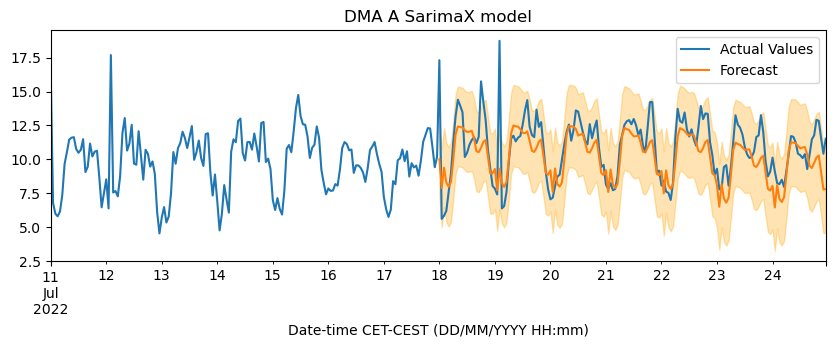

Performance indicators
DMA A SarimaX 26-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.74            7.30             1.14           10.18 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
3.67            9.31             2.96           15.94 



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18497D+00    |proj g|=  1.17971D+00

At iterate    5    f=  8.69826D-01    |proj g|=  5.21252D-01

At iterate   10    f=  7.19180D-01    |proj g|=  2.01779D-01

At iterate   15    f=  7.02452D-01    |proj g|=  1.10233D-01

At iterate   20    f=  6.80774D-01    |proj g|=  4.53910D-01

At iterate   25    f=  6.69493D-01    |proj g|=  1.48309D-01

At iterate   30    f=  6.62825D-01    |proj g|=  2.44242D-02

At iterate   35    f=  6.62356D-01    |proj g|=  3.04727D-02

At iterate   40    f=  6.62345D-01    |proj g|=  7.56490D-03

At iterate   45    f=  6.62333D-01    |proj g|=  3.69041D-03

At iterate   50    f=  6.62297D-01    |proj g|=  1.25138D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

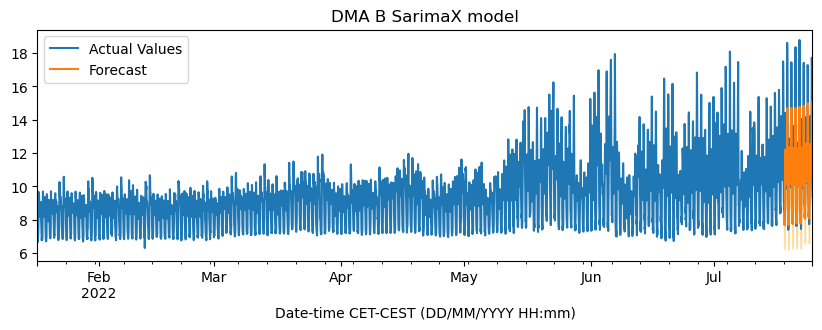

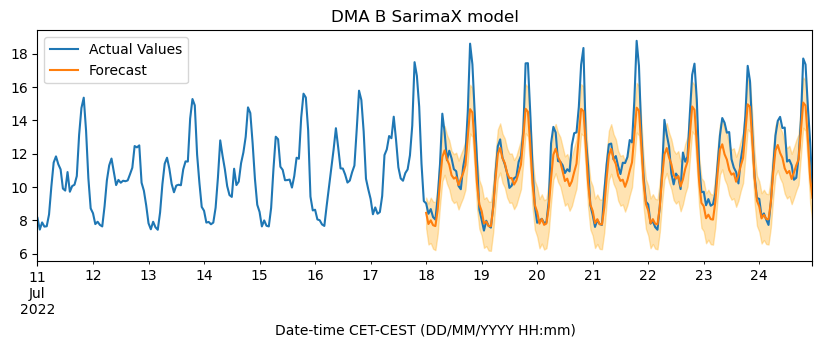

Performance indicators
DMA B SarimaX 26-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.03            3.93             0.88           5.84 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.66            9.37             2.76           14.78 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.66615D-01    |proj g|=  4.88701D-01


 This problem is unconstrained.



At iterate    5    f=  5.46096D-01    |proj g|=  9.70228D-01

At iterate   10    f=  5.36307D-01    |proj g|=  1.25184D+00

At iterate   15    f=  5.07799D-01    |proj g|=  6.24297D-01

At iterate   20    f=  4.90024D-01    |proj g|=  3.52774D-01

At iterate   25    f=  4.84613D-01    |proj g|=  5.86159D-01

At iterate   30    f=  4.78338D-01    |proj g|=  1.29511D-01

At iterate   35    f=  4.77451D-01    |proj g|=  1.09827D-01

At iterate   40    f=  4.77220D-01    |proj g|=  7.97448D-02

At iterate   45    f=  4.76923D-01    |proj g|=  7.11214D-02

At iterate   50    f=  4.76813D-01    |proj g|=  1.51346D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

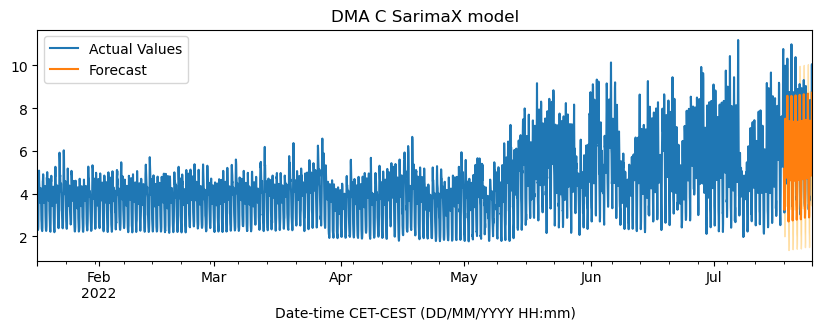

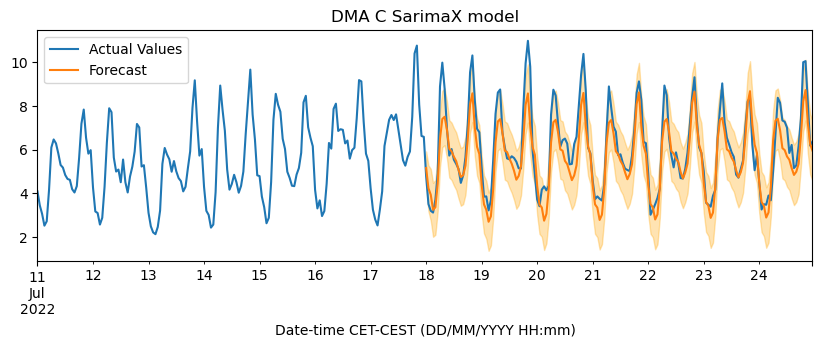

Performance indicators
DMA C SarimaX 26-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.73            2.58             0.64           3.95 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.28            6.07             2.07           10.42 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43384D+00    |proj g|=  9.45697D-02


 This problem is unconstrained.



At iterate    5    f=  2.35970D+00    |proj g|=  1.76970D-01

At iterate   10    f=  2.33835D+00    |proj g|=  3.72581D-02

At iterate   15    f=  2.32998D+00    |proj g|=  3.01475D-02

At iterate   20    f=  2.32814D+00    |proj g|=  8.47850D-03

At iterate   25    f=  2.32804D+00    |proj g|=  3.65895D-03

At iterate   30    f=  2.32797D+00    |proj g|=  2.86156D-03

At iterate   35    f=  2.32795D+00    |proj g|=  1.22962D-03

At iterate   40    f=  2.32794D+00    |proj g|=  8.53430D-03

At iterate   45    f=  2.32791D+00    |proj g|=  5.83326D-03

At iterate   50    f=  2.32789D+00    |proj g|=  1.63652D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

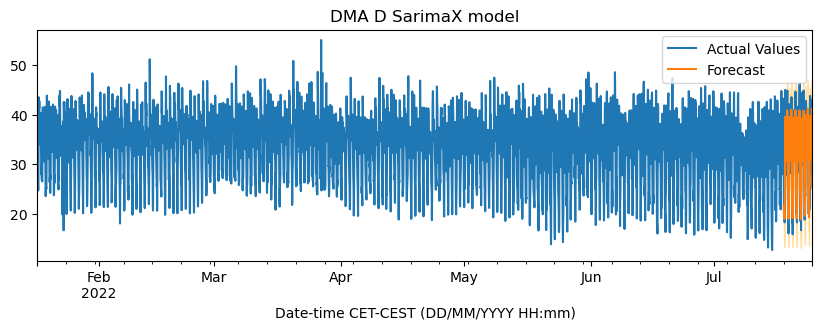

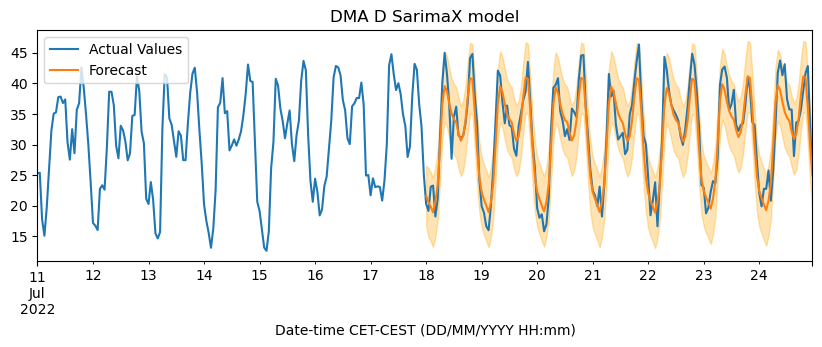

Performance indicators
DMA D SarimaX 26-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.32            7.40             2.34           12.05 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
6.76            14.87             6.45           28.09 



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43995D+00    |proj g|=  8.40294D-02

At iterate    5    f=  2.40935D+00    |proj g|=  2.75682D-01

At iterate   10    f=  2.33053D+00    |proj g|=  3.46364D-02

At iterate   15    f=  2.32593D+00    |proj g|=  1.41165D-02

At iterate   20    f=  2.32515D+00    |proj g|=  2.01753D-03

At iterate   25    f=  2.32504D+00    |proj g|=  4.52555D-03

At iterate   30    f=  2.32488D+00    |proj g|=  3.21410D-03

At iterate   35    f=  2.32466D+00    |proj g|=  2.50858D-03

At iterate   40    f=  2.32418D+00    |proj g|=  7.86225D-03

At iterate   45    f=  2.32327D+00    |proj g|=  2.52806D-02

At iterate   50    f=  2.32067D+00    |proj g|=  3.57006D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

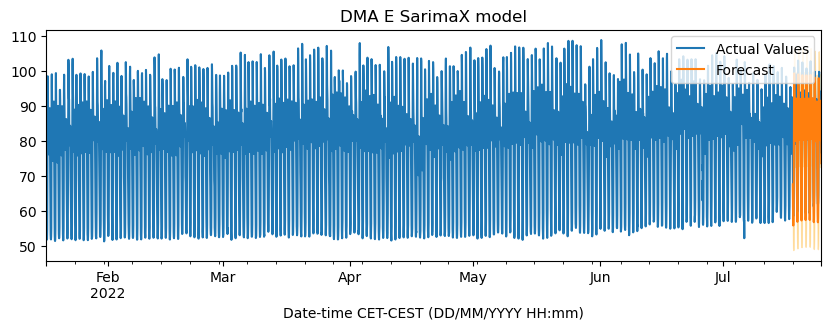

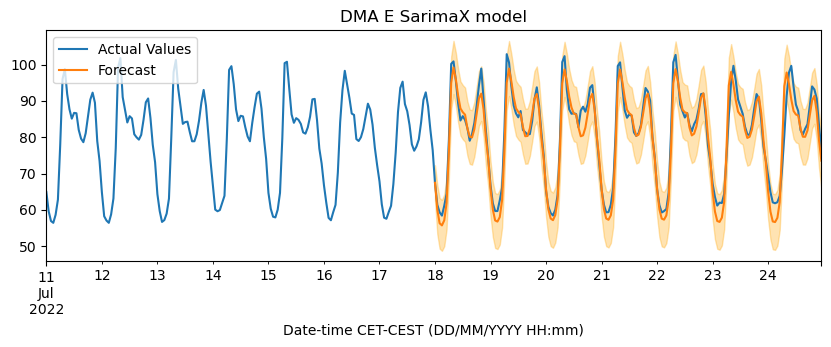

Performance indicators
DMA E SarimaX 26-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.25            6.90             2.41           11.56 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
11.66            23.42             11.31           46.39 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53008D+00    |proj g|=  2.53150D-01


 This problem is unconstrained.



At iterate    5    f=  1.48041D+00    |proj g|=  1.00112D-01

At iterate   10    f=  1.44255D+00    |proj g|=  2.44273D-01

At iterate   15    f=  1.43866D+00    |proj g|=  3.01118D-02

At iterate   20    f=  1.43739D+00    |proj g|=  1.89984D-03

At iterate   25    f=  1.43737D+00    |proj g|=  7.29741D-03

At iterate   30    f=  1.43709D+00    |proj g|=  7.90840D-03

At iterate   35    f=  1.43704D+00    |proj g|=  2.68010D-03

At iterate   40    f=  1.43699D+00    |proj g|=  1.06127D-02

At iterate   45    f=  1.43697D+00    |proj g|=  7.45904D-03

At iterate   50    f=  1.43696D+00    |proj g|=  1.41277D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

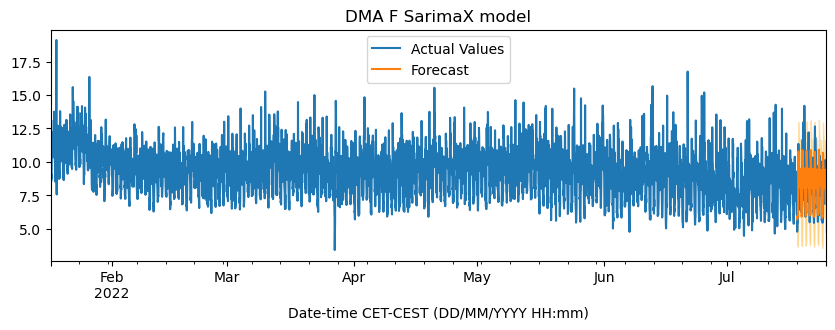

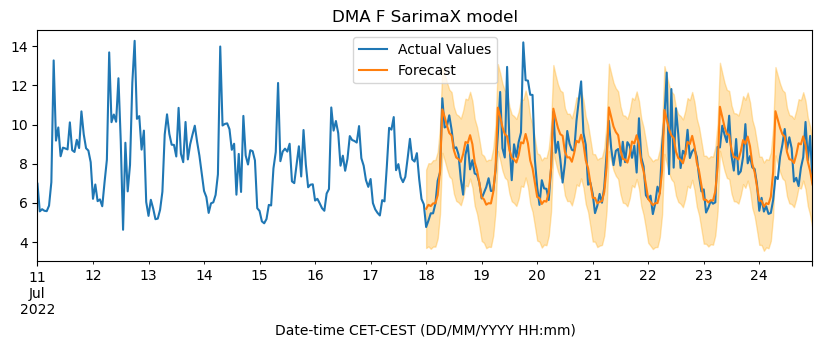

Performance indicators
DMA F SarimaX 26-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.57            2.08             0.92           3.57 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.78            4.36             1.61           7.75 



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.82590D+00    |proj g|=  1.16362D-01

At iterate    5    f=  1.76889D+00    |proj g|=  1.19161D-01

At iterate   10    f=  1.71427D+00    |proj g|=  2.70977D-02

At iterate   15    f=  1.70862D+00    |proj g|=  2.68964D-02

At iterate   20    f=  1.70854D+00    |proj g|=  4.68074D-03

At iterate   25    f=  1.70834D+00    |proj g|=  1.47274D-02

At iterate   30    f=  1.70827D+00    |proj g|=  5.42979D-03

At iterate   35    f=  1.70824D+00    |proj g|=  6.40630D-03

At iterate   40    f=  1.70820D+00    |proj g|=  1.39201D-03

At iterate   45    f=  1.70819D+00    |proj g|=  1.32215D-03

At iterate   50    f=  1.70814D+00    |proj g|=  5.73044D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

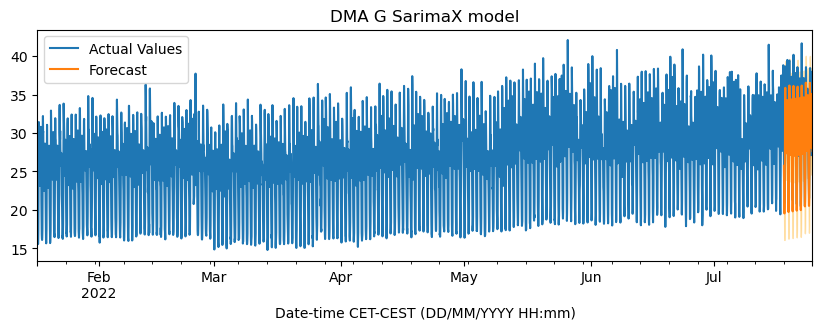

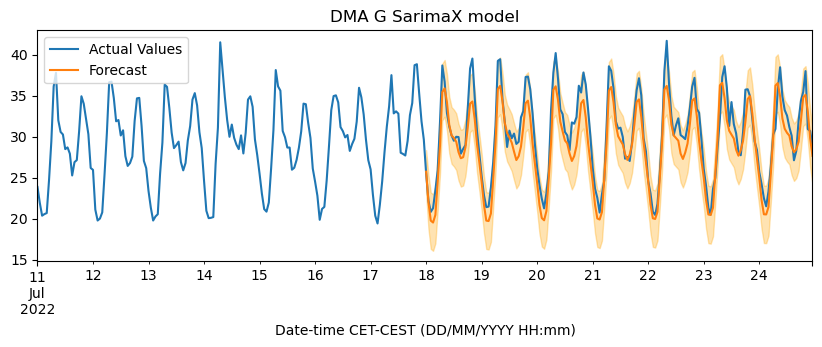

Performance indicators
DMA G SarimaX 26-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.57            5.23             1.86           8.66 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
5.47            13.63             5.81           24.91 



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.80228D+00    |proj g|=  7.96260D-01

At iterate    5    f=  1.54620D+00    |proj g|=  3.29893D-01

At iterate   10    f=  1.51530D+00    |proj g|=  1.42611D-01

At iterate   15    f=  1.44818D+00    |proj g|=  5.58407D-02

At iterate   20    f=  1.44181D+00    |proj g|=  1.54904D-02

At iterate   25    f=  1.44143D+00    |proj g|=  5.06643D-03

At iterate   30    f=  1.44118D+00    |proj g|=  5.56874D-02

At iterate   35    f=  1.44055D+00    |proj g|=  1.06152D-02

At iterate   40    f=  1.43980D+00    |proj g|=  2.03991D-02

At iterate   45    f=  1.43956D+00    |proj g|=  4.01846D-03

At iterate   50    f=  1.43954D+00    |proj g|=  3.67540D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

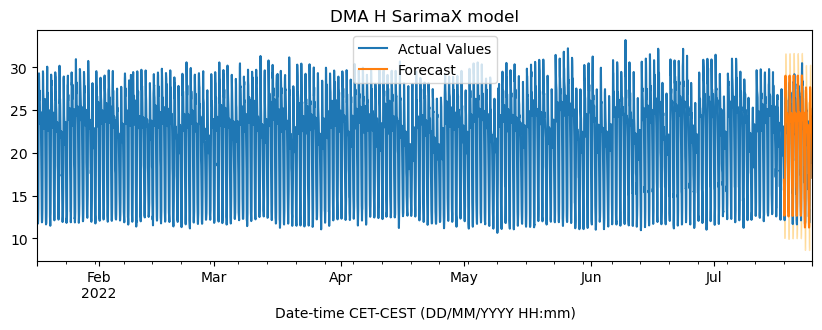

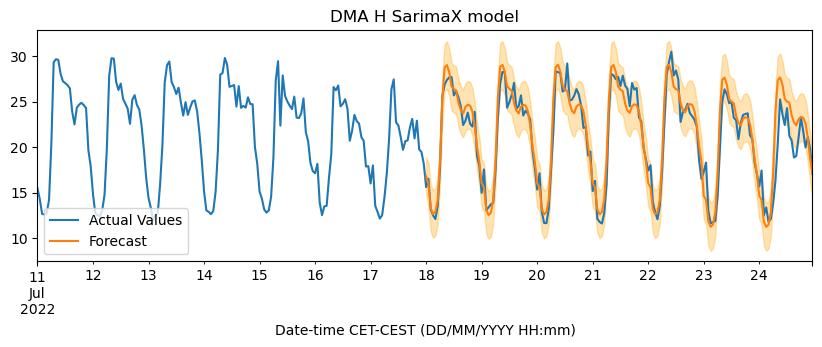

Performance indicators
DMA H SarimaX 26-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.92            2.00             1.33           4.24 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.58            9.04             4.52           18.14 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94208D+00    |proj g|=  1.73668D-01


 This problem is unconstrained.



At iterate    5    f=  1.86751D+00    |proj g|=  9.27583D-02

At iterate   10    f=  1.83343D+00    |proj g|=  1.31875D-01

At iterate   15    f=  1.82647D+00    |proj g|=  1.84668D-02

At iterate   20    f=  1.82579D+00    |proj g|=  8.19531D-03

At iterate   25    f=  1.82305D+00    |proj g|=  1.64377D-02

At iterate   30    f=  1.82249D+00    |proj g|=  3.54430D-03

At iterate   35    f=  1.82227D+00    |proj g|=  5.41646D-03

At iterate   40    f=  1.82197D+00    |proj g|=  6.94510D-03

At iterate   45    f=  1.82195D+00    |proj g|=  3.53200D-03

At iterate   50    f=  1.82188D+00    |proj g|=  8.29963D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

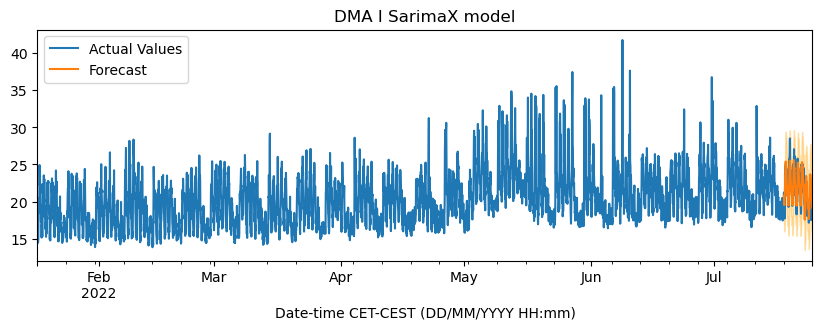

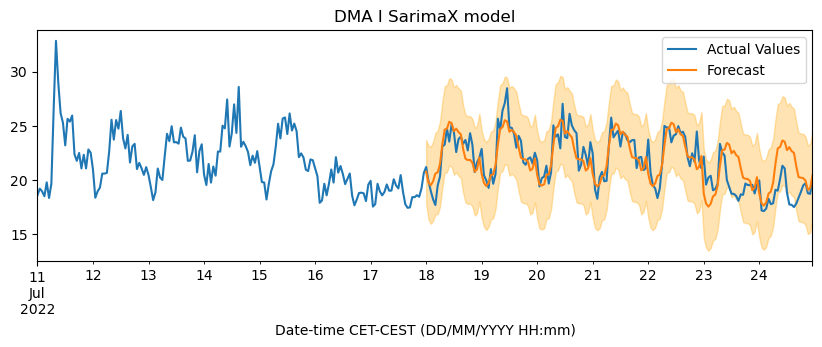

Performance indicators
DMA I SarimaX 26-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.94            2.90             1.27           5.11 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.55            4.98             2.28           9.81 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.86621D+00    |proj g|=  1.68793D-01


 This problem is unconstrained.



At iterate    5    f=  1.79942D+00    |proj g|=  1.05582D-01

At iterate   10    f=  1.74418D+00    |proj g|=  5.39007D-02

At iterate   15    f=  1.73254D+00    |proj g|=  3.09937D-02

At iterate   20    f=  1.73219D+00    |proj g|=  2.52005D-02

At iterate   25    f=  1.73163D+00    |proj g|=  5.04921D-02

At iterate   30    f=  1.72930D+00    |proj g|=  2.17544D-02

At iterate   35    f=  1.72896D+00    |proj g|=  3.00436D-02

At iterate   40    f=  1.72859D+00    |proj g|=  1.58869D-02

At iterate   45    f=  1.72834D+00    |proj g|=  7.19150D-03

At iterate   50    f=  1.72740D+00    |proj g|=  5.81083D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

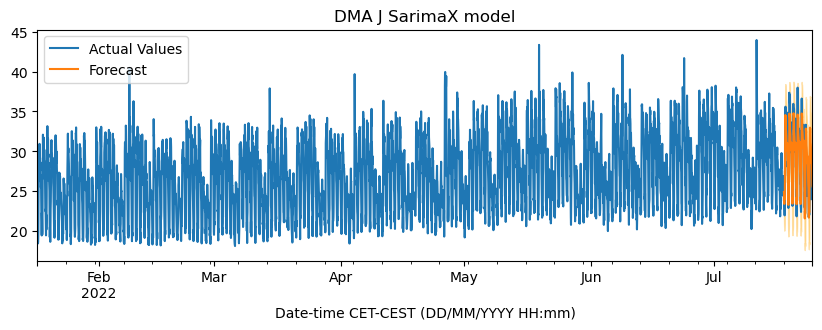

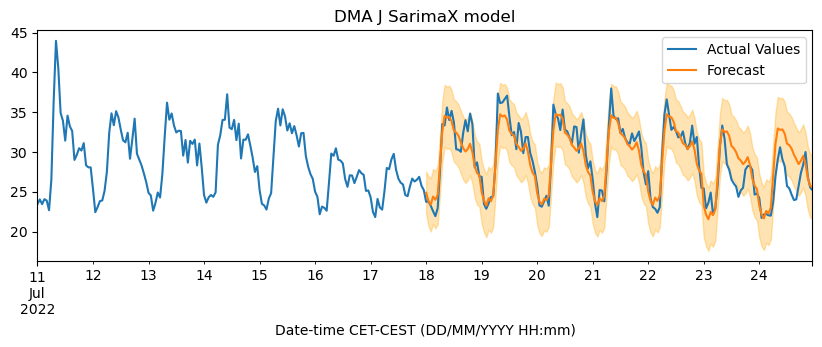

Performance indicators
DMA J SarimaX 26-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.49            3.93             1.50           6.92 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.77            8.76             3.93           17.46 



In [6]:
# make empty datafram to store results
results_df = pd.DataFrame()

# make dictionary with dma position in description list
dict_dma = dict(zip(dma_list, np.arange(0,len(dma_list))))

# select dma for analysis
for dma in list(inflow_data.columns):
    
    # copy data from dataframe in a new time series dataframe
    tseries_df = inflow_data[dma][start:end].copy()

    # fill missing values with interpolation technique
    #tseries_df.interpolate(limit_direction='both',inplace=True)

    # # plot original and interpolated time series for selected dma
    # fig, ax = plt.subplots()
    # tseries_df.plot(label='Interpolated')
    # inflow_data[dma][start:end].plot(y=dma_list[i],use_index=True,ax = ax,figsize=(25,5), linewidth=1, label='Original')
    # plt.title(dma_list[dict_dma[dma]] + ". " + dma_descripton[dict_dma[dma]] +". "+ str(users_supplied[dict_dma[dma]]) + " users supplied. ")
    # plt.xlabel("Date")
    # plt.ylabel("L/s")
    # plt.legend()
    # plt.show()

    # demand time series
    y = tseries_df
    y_train, y_test = temporal_train_test_split(y, test_size = 168)

    # exogenous variables time series
    X = tseriesX_df
    X_train, X_test = temporal_train_test_split(X, test_size=168)

    #Naive Forecaster
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    forecaster = NaiveForecaster(strategy = 'mean')
    forecaster.fit(y_train)
    # results of naive forecaster
    y_pred_naive = forecaster.predict(fh)

    # #print results (optional)
    # fig, ax = plt.subplots(figsize = (10,3))
    # tseries_df.plot(title = 'Naive Forecaster', ax = ax)
    # y_pred_naive.plot(ax = ax)
    # ax.legend(['Actual Values', 'Forecast'])
    # plt.show()

    # implement sarimaX model    
    # the statsmodel package applies the difference already if needed.

    #model = SARIMAX(y_train, exog=X_train, order=(2,0,2), seasonal_order=(0,1,1,24)) # add seasonality of 24 hrs
    model = SARIMAX(y_train, exog=X_train, order=(4,0,3), seasonal_order=(0,1,1,24)) # add seasonality of 24 hrs
    model_fit = model.fit()
    # print(model_fit.summary())

    y_pred = model_fit.get_forecast(len(y_test), exog=X_test).summary_frame(alpha=0.05)

    # plot forecast and full time series length
    fig, ax = plt.subplots(figsize = (10,3))
    tseries_df.plot(title = dma[:5]+' SarimaX model', ax = ax)
    y_pred.plot(y='mean',ax = ax)
    ax.fill_between(y_pred.index, y_pred['mean_ci_lower'], y_pred['mean_ci_upper'],color='orange', alpha=0.3)
    ax.legend(['Actual Values', 'Forecast'])
    plt.show()

    # plot forecast and last two weeks of time series
    fig, ax = plt.subplots(figsize = (10,3))
    tseries_df['2022-07-11':'2022-07-24'].plot(title = dma[:5]+' SarimaX model', ax = ax)
    y_pred.plot(y='mean',ax = ax)
    ax.fill_between(y_pred.index, y_pred['mean_ci_lower'], y_pred['mean_ci_upper'],color='orange', alpha=0.3)
    ax.legend(['Actual Values', 'Forecast'])
    plt.show()

    print('Performance indicators')
    df = print_metrics(y_test, y_pred['mean'], dma[:5]+' SarimaX 26-Weeks',return_df=1)
    results_df = pd.concat([results_df, df])
    print_metrics(y_test, y_pred_naive, 'Naive Forecaster')

In [7]:
results_df

,MeanAE-24h,MaxAE-24h,MeanAE-144h,Total
DMA A SarimaX 26-Weeks,1.738,7.300,1.140,10.178
DMA B SarimaX 26-Weeks,1.032,3.927,0.878,5.836
DMA C SarimaX 26-Weeks,0.726,2.582,0.638,3.946
DMA D SarimaX 26-Weeks,2.322,7.396,2.337,12.055
DMA E SarimaX 26-Weeks,2.251,6.895,2.412,11.558
DMA F SarimaX 26-Weeks,0.571,2.076,0.920,3.566
DMA G SarimaX 26-Weeks,1.574,5.229,1.860,8.664
DMA H SarimaX 26-Weeks,0.917,1.996,1.329,4.241
DMA I SarimaX 26-Weeks,0.939,2.903,1.270,5.113
DMA J SarimaX 26-Weeks,1.490,3.933,1.501,6.924


In [8]:
print(f"{results_df['Total'].sum() :.2f}")

72.08


In [9]:
print(f"{results_df.drop('DMA E SarimaX 26-Weeks')['Total'].sum() :.2f}")

60.52
